# 0. Load and prepare data 

In [8]:
# test
import numpy as np
np.random.seed(123123)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load csv file with pandas
df = pd.read_csv('data/diabetes.csv')

# drop all na values
df = df.dropna()


# X and y
X = df.drop('Outcome', axis=1).values  # shape: (n_samples, 8)
y = df['Outcome'].values.reshape(-1, 1)  # shape: (n_samples, 1)

# basic Scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123123)


print(X_train.shape)  # (614, 8)
print(y_train.shape)  # (614, 1)

(537, 8)
(537, 1)


# 1. Own Implementation

In [ ]:
# imports

#from scipy.special import expit  # Sigmoid

In [9]:
# import NeuralNetwork from Implementation/NeuralNetwork.py
from Implementation.NeuralNetwork import NeuralNetwork  


## Train the Network 


=== Training Model 1/3 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693146 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.647922 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.433852 | Train Acc = 0.7840 | Test Acc = 0.7792
Epoch 30000: Loss = 0.385584 | Train Acc = 0.8194 | Test Acc = 0.7835
Epoch 40000: Loss = 0.311005 | Train Acc = 0.8696 | Test Acc = 0.7965
Epoch 50000: Loss = 0.224786 | Train Acc = 0.9125 | Test Acc = 0.7749
Epoch 60000: Loss = 0.141598 | Train Acc = 0.9534 | Test Acc = 0.7792
Epoch 70000: Loss = 0.086518 | Train Acc = 0.9832 | Test Acc = 0.7403
Epoch 80000: Loss = 0.055805 | Train Acc = 0.9907 | Test Acc = 0.7359
Epoch 90000: Loss = 0.034027 | Train Acc = 0.9963 | Test Acc = 0.7359
Epoch 100000: Loss = 0.019921 | Train Acc = 1.0000 | Test Acc = 0.7359
Epoch 110000: Loss = 0.012018 | Train Acc = 1.0000 | Test 

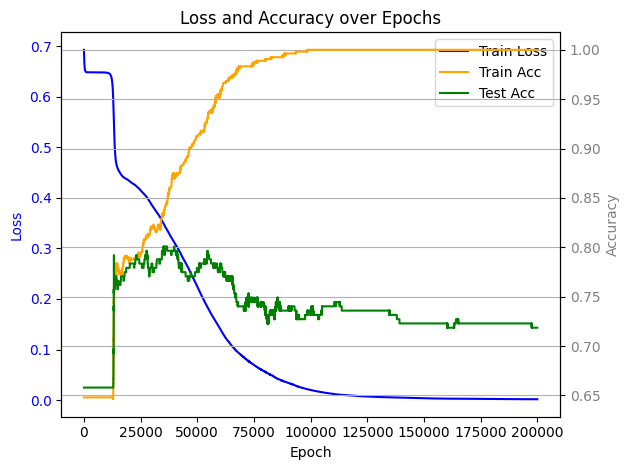


Minimum loss: 0.001568
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8009

=== Training Model 2/3 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.698907 | Train Acc = 0.3520 | Test Acc = 0.3420
Epoch 10000: Loss = 0.648626 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648578 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648434 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.647876 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.643406 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.497776 | Train Acc = 0.7747 | Test Acc = 0.7662
Epoch 70000: Loss = 0.465910 | Train Acc = 0.7747 | Test Acc = 0.7662
Epoch 80000: Loss = 0.465291 | Train Acc = 0.7709 | Test Acc = 0.7706
Epoch 90000: Loss = 0.465038 | Train Acc = 0.7691 | Test Acc = 0.7706
Epoch 100000: Loss = 0.464760 | Train Acc

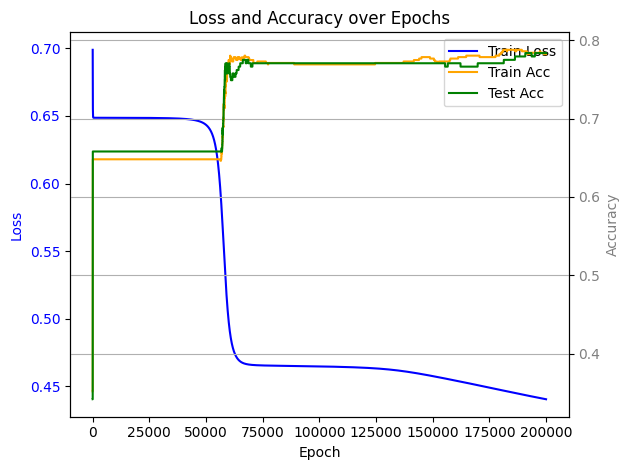


Minimum loss: 0.440470
Maximum train accuracy: 0.7877
Maximum test accuracy: 0.7835

=== Training Model 3/3 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693154 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.465989 | Train Acc = 0.7765 | Test Acc = 0.7706
Epoch 20000: Loss = 0.461525 | Train Acc = 0.7709 | Test Acc = 0.7662
Epoch 30000: Loss = 0.449180 | Train Acc = 0.7896 | Test Acc = 0.7792
Epoch 40000: Loss = 0.417916 | Train Acc = 0.7933 | Test Acc = 0.7879
Epoch 50000: Loss = 0.370888 | Train Acc = 0.8250 | Test Acc = 0.7619
Epoch 60000: Loss = 0.329268 | Train Acc = 0.8603 | Test Acc = 0.7576
Epoch 70000: Loss = 0.287029 | Train Acc = 0.8790 | Test Acc = 0.7359
Epoch 80000: Loss = 0.245239 | Train Acc = 0.8976 | Test Acc = 0.7229
Epoch 90000: Loss = 0.191150 | Train Acc = 0.9348 | Test Acc = 0.7229
Epoch 100000: Loss = 0.124933 | Train Acc = 

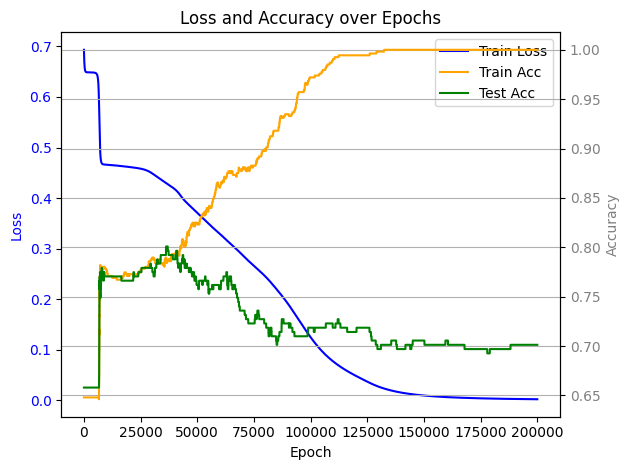


Minimum loss: 0.002403
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8009


In [32]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    train_accuracies = []   # neu
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Train-Accuracy berechnen
        y_pred_train = model.predict(X_train)
        y_pred_train_bin = (y_pred_train > 0.5).astype(int)
        acc_train = accuracy_score(y_train, y_pred_train_bin)
        train_accuracies.append(acc_train)

        # Test-Accuracy (falls verfügbar)
        if X_test is not None and y_test is not None:
            y_pred_test = model.predict(X_test)
            y_pred_test_bin = (y_pred_test > 0.5).astype(int)
            acc_test = accuracy_score(y_test, y_pred_test_bin)
            test_accuracies.append(acc_test)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}", end='')
            if X_test is not None:
                print(f" | Test Acc = {acc_test:.4f}")
            else:
                print()

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Accuracies
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc", color='orange')
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Acc", color='green')
    ax2.set_ylabel("Accuracy", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Legende zusammenführen
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")
    
    return losses, train_accuracies, test_accuracies




# Diabetes Dataset:
parameter_grid = [
    # Regularization - Comparison
    #{'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
    #{'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.001},
    #{'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.003},
    
    # neurons
    #{'input_size': 8, 'hidden1_size': 4, 'hidden2_size': 2, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00}, # rule of thumb: 2/3 of input size
    #{'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00}, 
    #{'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00},
    #{'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.001},
    #{'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00},
    
    
    # Learning rates - Separate functiom
    #{'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    #{'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    #{'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 

    

    # Activation Functions
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
]

results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, train_accuracies, test_accuracies = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=200000,
        patience=200000,
        print_every=10000
)
    
    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })





=== Training Model 1/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693143 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.649032 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648643 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648635 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648628 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648617 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648596 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.648552 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.648447 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 90000: Loss = 0.648117 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 100000: Loss = 0.646467 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 110000: Loss = 0.625133 | Train Acc = 0.6480 | Test A

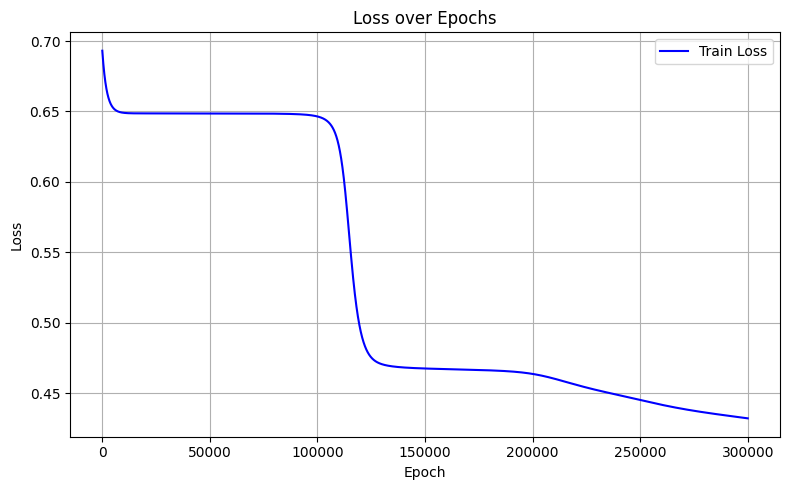


Minimum loss: 0.432118

=== Training Model 2/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693149 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648648 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648641 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648594 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.623609 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.466412 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 80000: Loss = 0.460047 | Train Acc = 0.7765 | Test Acc = 0.7662
Epoch 90000: Loss = 0.445584 | Train Acc = 0.7821 | Test Acc = 0.7922
Epoch 100000: Loss = 0.430328 | Train Acc = 0.7877 | Test Acc = 0.8009
Epoch 110000: Loss = 0.409098 | Tra

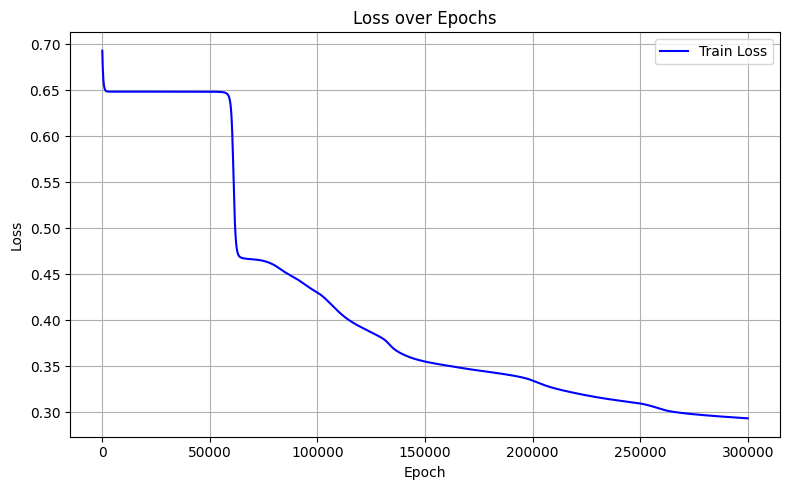


Minimum loss: 0.293590

=== Training Model 3/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693143 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.641496 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465238 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 30000: Loss = 0.441322 | Train Acc = 0.7914 | Test Acc = 0.7965
Epoch 40000: Loss = 0.412629 | Train Acc = 0.8026 | Test Acc = 0.7706
Epoch 50000: Loss = 0.368181 | Train Acc = 0.8250 | Test Acc = 0.7749
Epoch 60000: Loss = 0.351645 | Train Acc = 0.8305 | Test Acc = 0.7619
Epoch 70000: Loss = 0.341235 | Train Acc = 0.8436 | Test Acc = 0.7792
Epoch 80000: Loss = 0.327712 | Train Acc = 0.8510 | Test Acc = 0.7749
Epoch 90000: Loss = 0.315480 | Train Acc = 0.8566 | Test Acc = 0.7749
Epoch 100000: Loss = 0.308825 | Train Acc = 0.8585 | Test Acc = 0.7706
Epoch 110000: Loss = 0.303626 | Trai

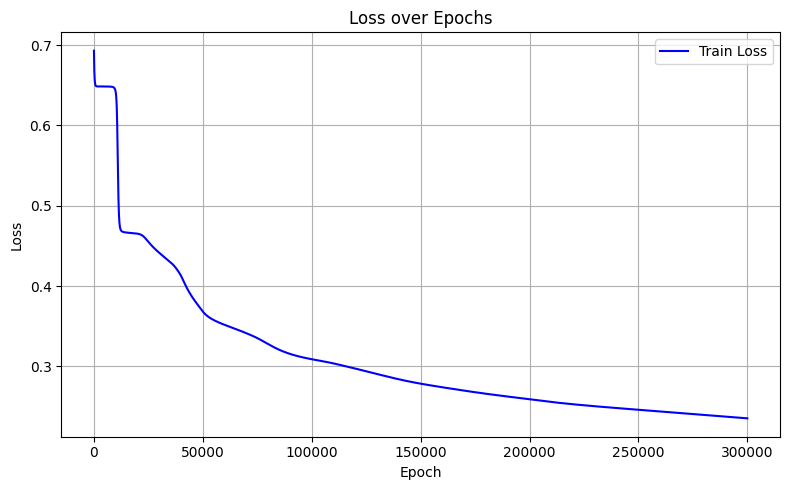


Minimum loss: 0.235202

=== Training Model 4/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.427258 | Train Acc = 0.7821 | Test Acc = 0.7662
Epoch 20000: Loss = 0.356930 | Train Acc = 0.8175 | Test Acc = 0.7576
Epoch 30000: Loss = 0.308482 | Train Acc = 0.8510 | Test Acc = 0.7316
Epoch 40000: Loss = 0.288440 | Train Acc = 0.8622 | Test Acc = 0.7229
Epoch 50000: Loss = 0.267304 | Train Acc = 0.8659 | Test Acc = 0.7100
Epoch 60000: Loss = 0.251751 | Train Acc = 0.8734 | Test Acc = 0.7013
Epoch 70000: Loss = 0.238033 | Train Acc = 0.8734 | Test Acc = 0.6883
Epoch 80000: Loss = 0.228667 | Train Acc = 0.8845 | Test Acc = 0.6797
Epoch 90000: Loss = 0.223194 | Train Acc = 0.8845 | Test Acc = 0.6883
Epoch 100000: Loss = 0.217560 | Train Acc = 0.8883 | Test Acc = 0.6926
Epoch 110000: Loss = 0.208786 | Trai

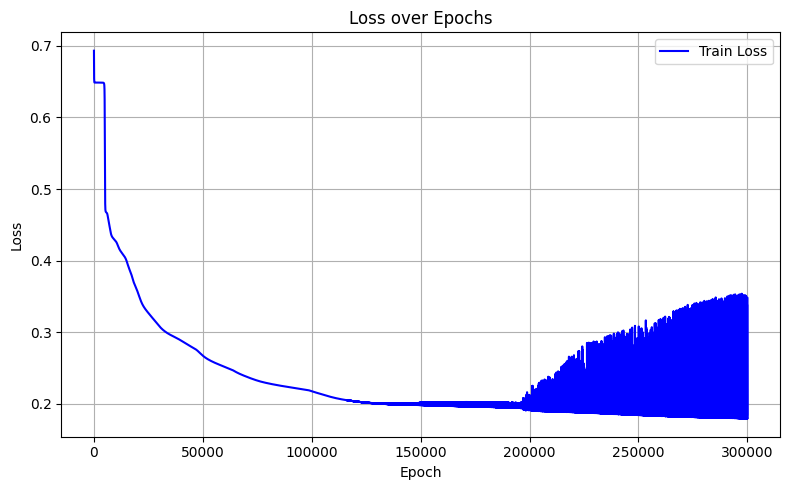


Minimum loss: 0.179820

=== Training Model 5/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.306829 | Train Acc = 0.8641 | Test Acc = 0.7273
Epoch 20000: Loss = 0.251959 | Train Acc = 0.8808 | Test Acc = 0.7229
Epoch 30000: Loss = 0.233687 | Train Acc = 0.8883 | Test Acc = 0.7273
Epoch 40000: Loss = 0.224137 | Train Acc = 0.8920 | Test Acc = 0.7273
Epoch 50000: Loss = 0.204900 | Train Acc = 0.8976 | Test Acc = 0.7100
Epoch 60000: Loss = 0.195534 | Train Acc = 0.9013 | Test Acc = 0.7143
Epoch 70000: Loss = 0.190209 | Train Acc = 0.9050 | Test Acc = 0.7100
Epoch 80000: Loss = 0.186563 | Train Acc = 0.9032 | Test Acc = 0.7143
Epoch 90000: Loss = 0.189509 | Train Acc = 0.9088 | Test Acc = 0.7056
Epoch 100000: Loss = 0.181897 | Train Acc = 0.9143 | Test Acc = 0.7100
Epoch 110000: Loss = 0.180110 | Train

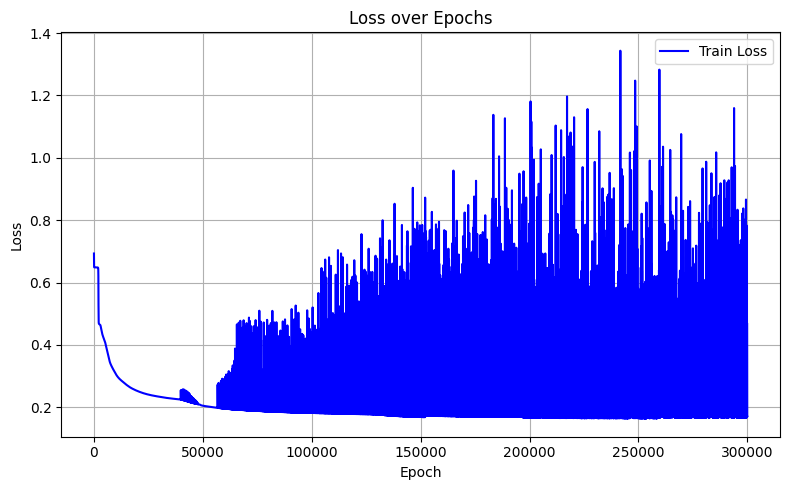


Minimum loss: 0.164392


In [31]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Optional: Accuracy für Konsole (wird nicht geplottet)
        if print_every and epoch % print_every == 0:
            y_pred_train = model.predict(X_train)
            y_pred_train_bin = (y_pred_train > 0.5).astype(int)
            acc_train = accuracy_score(y_train, y_pred_train_bin)

            if X_test is not None:
                y_pred_test = model.predict(X_test)
                y_pred_test_bin = (y_pred_test > 0.5).astype(int)
                acc_test = accuracy_score(y_test, y_pred_test_bin)
                print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f} | Test Acc = {acc_test:.4f}")
            else:
                print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}")

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot nur für Loss
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    
    return losses, None, None


# Parameter Grid
parameter_grid = [
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'tanh', 'l2_lambda': 0.00},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}
]

results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, _, _ = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=500000,
        patience=200000,
        print_every=10000
    )
    
    results.append({
        'params': params,
        'min_loss': min(losses)
    })



=== Training Model 1/15 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693146 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.639197 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.415158 | Train Acc = 0.7989 | Test Acc = 0.7879
Epoch 30000: Loss = 0.349228 | Train Acc = 0.8417 | Test Acc = 0.7835
Epoch 40000: Loss = 0.259606 | Train Acc = 0.8976 | Test Acc = 0.7965
Epoch 50000: Loss = 0.136092 | Train Acc = 0.9646 | Test Acc = 0.7749
Epoch 60000: Loss = 0.057066 | Train Acc = 0.9888 | Test Acc = 0.7792
Epoch 70000: Loss = 0.027288 | Train Acc = 0.9981 | Test Acc = 0.7706
Epoch 80000: Loss = 0.014558 | Train Acc = 1.0000 | Test Acc = 0.7706
Epoch 90000: Loss = 0.009014 | Train Acc = 1.0000 | Test Acc = 0.7749
Epoch 100000: Loss = 0.006177 | Train Acc = 1.0000 | Test Acc = 0.7706
Epoch 110000: Loss = 0.004458 | Train Acc = 1.0000 | Test

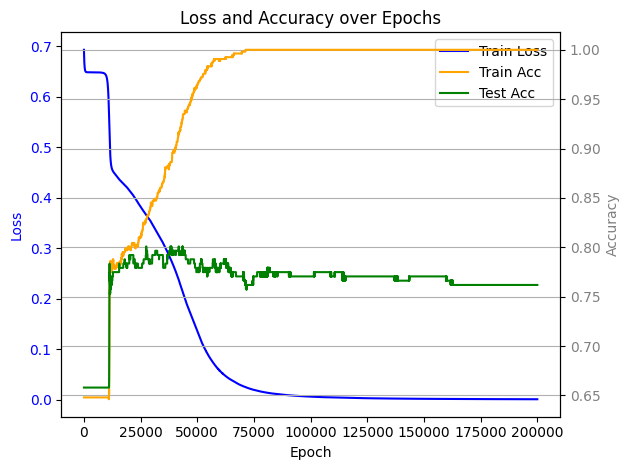


Minimum loss: 0.000970
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8009

=== Training Model 2/15 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693152 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.496510 | Train Acc = 0.7803 | Test Acc = 0.7576
Epoch 20000: Loss = 0.414959 | Train Acc = 0.8007 | Test Acc = 0.7922
Epoch 30000: Loss = 0.354936 | Train Acc = 0.8287 | Test Acc = 0.7965
Epoch 40000: Loss = 0.289550 | Train Acc = 0.8808 | Test Acc = 0.7965
Epoch 50000: Loss = 0.197680 | Train Acc = 0.9385 | Test Acc = 0.7879
Epoch 60000: Loss = 0.113675 | Train Acc = 0.9739 | Test Acc = 0.7662
Epoch 70000: Loss = 0.059152 | Train Acc = 0.9944 | Test Acc = 0.7792
Epoch 80000: Loss = 0.039695 | Train Acc = 1.0000 | Test Acc = 0.7706
Epoch 90000: Loss = 0.030049 | Train Acc = 1.0000 | Test Acc = 0.7619
Epoch 100000: Loss = 0.025363 | Train Acc

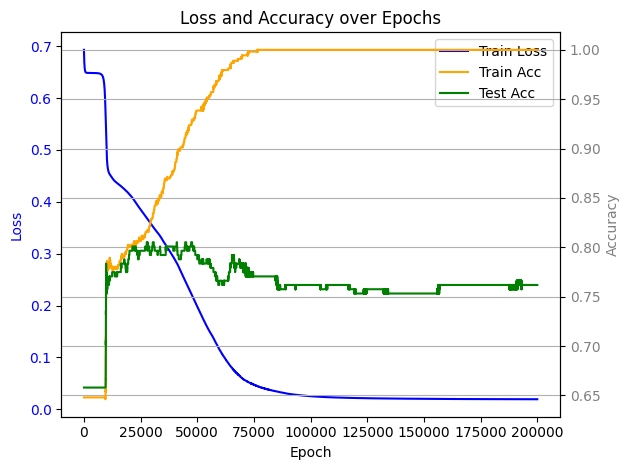


Minimum loss: 0.019433
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8052

=== Training Model 3/15 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002}
Epoch 0: Loss = 0.693148 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.587937 | Train Acc = 0.6462 | Test Acc = 0.6580
Epoch 20000: Loss = 0.424368 | Train Acc = 0.7914 | Test Acc = 0.7749
Epoch 30000: Loss = 0.376724 | Train Acc = 0.8138 | Test Acc = 0.7879
Epoch 40000: Loss = 0.317183 | Train Acc = 0.8659 | Test Acc = 0.7965
Epoch 50000: Loss = 0.261402 | Train Acc = 0.9013 | Test Acc = 0.7922
Epoch 60000: Loss = 0.199230 | Train Acc = 0.9274 | Test Acc = 0.7706
Epoch 70000: Loss = 0.152980 | Train Acc = 0.9516 | Test Acc = 0.7576
Epoch 80000: Loss = 0.115738 | Train Acc = 0.9721 | Test Acc = 0.7359
Epoch 90000: Loss = 0.090146 | Train Acc = 0.9870 | Test Acc = 0.7359
Epoch 100000: Loss = 0.070737 | Train Acc

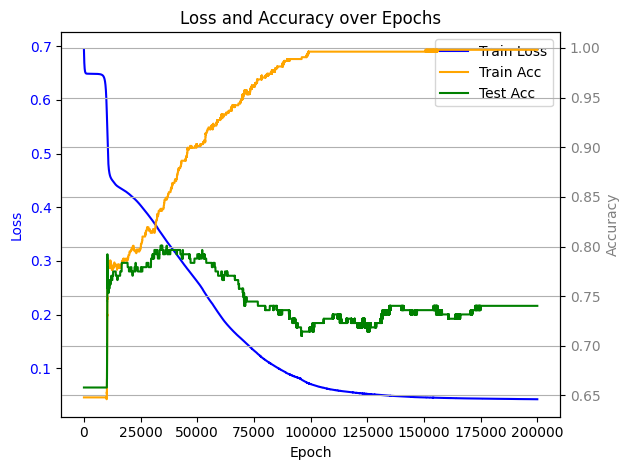


Minimum loss: 0.042564
Maximum train accuracy: 0.9981
Maximum test accuracy: 0.8009

=== Training Model 4/15 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.003}
Epoch 0: Loss = 0.693164 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.647990 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.435956 | Train Acc = 0.7821 | Test Acc = 0.7792
Epoch 30000: Loss = 0.394801 | Train Acc = 0.8082 | Test Acc = 0.7835
Epoch 40000: Loss = 0.353077 | Train Acc = 0.8399 | Test Acc = 0.7792
Epoch 50000: Loss = 0.298461 | Train Acc = 0.8808 | Test Acc = 0.7835
Epoch 60000: Loss = 0.228927 | Train Acc = 0.9125 | Test Acc = 0.7792
Epoch 70000: Loss = 0.167318 | Train Acc = 0.9404 | Test Acc = 0.7749
Epoch 80000: Loss = 0.120029 | Train Acc = 0.9702 | Test Acc = 0.7749


KeyboardInterrupt: 

In [37]:
### New trainging

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    train_accuracies = []   # neu
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Train-Accuracy berechnen
        y_pred_train = model.predict(X_train)
        y_pred_train_bin = (y_pred_train > 0.5).astype(int)
        acc_train = accuracy_score(y_train, y_pred_train_bin)
        train_accuracies.append(acc_train)

        # Test-Accuracy (falls verfügbar)
        if X_test is not None and y_test is not None:
            y_pred_test = model.predict(X_test)
            y_pred_test_bin = (y_pred_test > 0.5).astype(int)
            acc_test = accuracy_score(y_test, y_pred_test_bin)
            test_accuracies.append(acc_test)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}", end='')
            if X_test is not None:
                print(f" | Test Acc = {acc_test:.4f}")
            else:
                print()

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Accuracies
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc", color='orange')
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Acc", color='green')
    ax2.set_ylabel("Accuracy", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Legende zusammenführen
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")
    
    return losses, train_accuracies, test_accuracies




# Diabetes Dataset:
parameter_grid = [
    # Small hidden layers
    


    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.003},
    

    #{'input_size': 8, 'hidden1_size': 8,  'hidden2_size': 4,  'output_size': 1, 'lr': 0.001, 'activation_hidden': 'relu', 'l2_lambda': 0.001},

    # Number of neurons
    {'input_size': 8, 'hidden1_size': 4, 'hidden2_size': 2, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 128, 'hidden2_size': 64, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 256, 'hidden2_size': 128, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},




    # Learning rates 
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.002},

    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001},

    # Large hidden layers
    {'input_size': 8, 'hidden1_size': 128, 'hidden2_size': 64, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 128, 'hidden2_size': 64, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 128, 'hidden2_size': 64, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
]


results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, train_accuracies, test_accuracies = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=200000,
        patience=200000,
        print_every=10000
)
    
    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })





=== Training Model 1/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693149 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648093 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.439462 | Train Acc = 0.7803 | Test Acc = 0.7662
Epoch 30000: Loss = 0.384636 | Train Acc = 0.8063 | Test Acc = 0.7792
Epoch 40000: Loss = 0.330499 | Train Acc = 0.8454 | Test Acc = 0.7792
Epoch 50000: Loss = 0.263654 | Train Acc = 0.8845 | Test Acc = 0.7965
Epoch 60000: Loss = 0.179483 | Train Acc = 0.9330 | Test Acc = 0.7662
Epoch 70000: Loss = 0.105980 | Train Acc = 0.9721 | Test Acc = 0.7532
Epoch 80000: Loss = 0.051394 | Train Acc = 0.9944 | Test Acc = 0.7273
Epoch 90000: Loss = 0.027081 | Train Acc = 0.9981 | Test Acc = 0.7359
Epoch 100000: Loss = 0.016402 | Train Acc = 1.0000 | Test Acc = 0.7403
Epoch 110000: Loss = 0.010910 | Train Acc = 1.0000 | Test

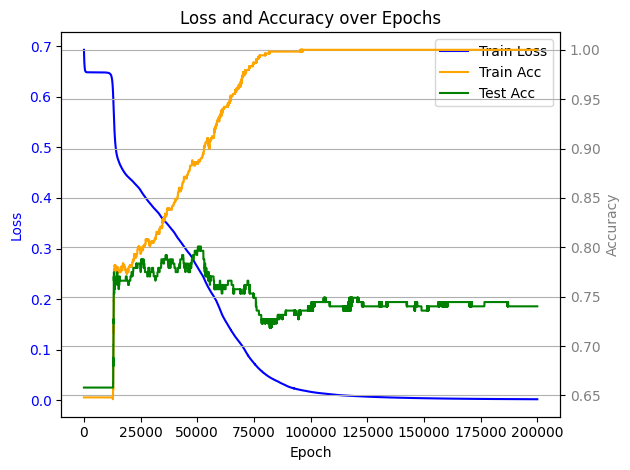


Minimum loss: 0.001740
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8009

=== Training Model 2/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648119 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.437391 | Train Acc = 0.7803 | Test Acc = 0.7749
Epoch 30000: Loss = 0.392137 | Train Acc = 0.8156 | Test Acc = 0.7749
Epoch 40000: Loss = 0.342294 | Train Acc = 0.8417 | Test Acc = 0.7922
Epoch 50000: Loss = 0.299069 | Train Acc = 0.8827 | Test Acc = 0.7922
Epoch 60000: Loss = 0.240327 | Train Acc = 0.9050 | Test Acc = 0.7965
Epoch 70000: Loss = 0.187687 | Train Acc = 0.9292 | Test Acc = 0.7749
Epoch 80000: Loss = 0.150385 | Train Acc = 0.9553 | Test Acc = 0.7749
Epoch 90000: Loss = 0.116792 | Train Acc = 0.9646 | Test Acc = 0.7576
Epoch 100000: Loss = 0.085665 | Train Acc

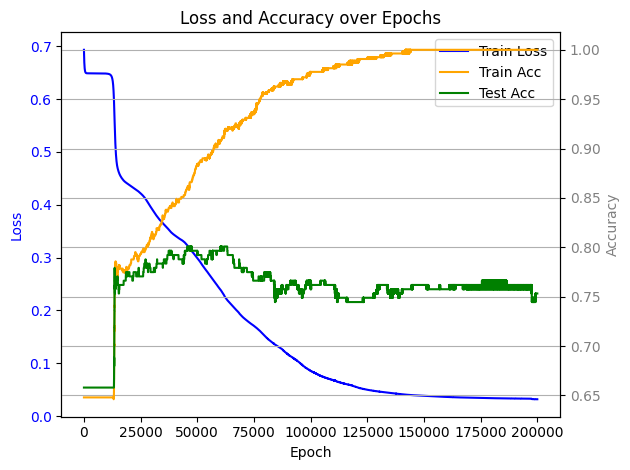


Minimum loss: 0.031877
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8009

=== Training Model 3/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.01}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648646 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648648 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 90000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 100000: Loss = 0.648649 | Train Acc 

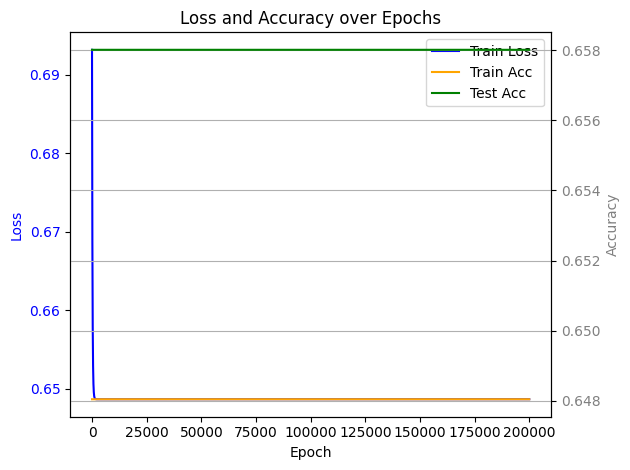


Minimum loss: 0.648644
Maximum train accuracy: 0.6480
Maximum test accuracy: 0.6580

=== Training Model 4/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693146 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648645 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648621 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.602095 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.430525 | Train Acc = 0.7914 | Test Acc = 0.7965
Epoch 50000: Loss = 0.413033 | Train Acc = 0.7970 | Test Acc = 0.7835
Epoch 60000: Loss = 0.403981 | Train Acc = 0.8063 | Test Acc = 0.7879
Epoch 70000: Loss = 0.392760 | Train Acc = 0.8231 | Test Acc = 0.7879
Epoch 80000: Loss = 0.388376 | Train Acc = 0.8194 | Test Acc = 0.7835
Epoch 90000: Loss = 0.386617 | Train Acc = 0.8231 | Test Acc = 0.7792
Epoch 100000: Loss = 0.386085 | Train Acc =

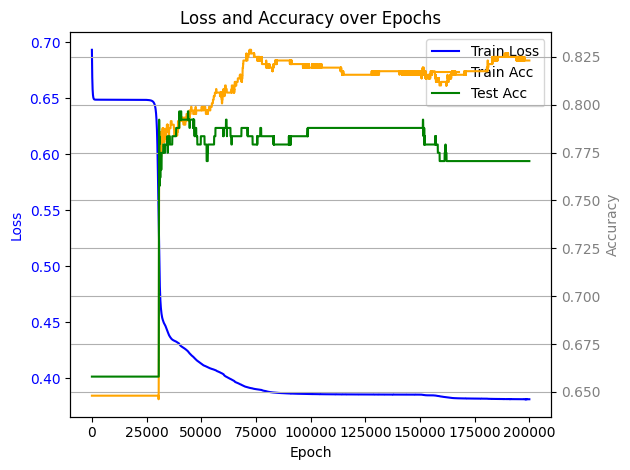


Minimum loss: 0.381436
Maximum train accuracy: 0.8287
Maximum test accuracy: 0.7965

=== Training Model 5/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693148 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648550 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.445026 | Train Acc = 0.7709 | Test Acc = 0.7706
Epoch 30000: Loss = 0.408386 | Train Acc = 0.8007 | Test Acc = 0.7922
Epoch 40000: Loss = 0.361152 | Train Acc = 0.8250 | Test Acc = 0.7792
Epoch 50000: Loss = 0.318469 | Train Acc = 0.8529 | Test Acc = 0.7965
Epoch 60000: Loss = 0.281987 | Train Acc = 0.8696 | Test Acc = 0.7879
Epoch 70000: Loss = 0.246450 | Train Acc = 0.8920 | Test Acc = 0.7662
Epoch 80000: Loss = 0.205224 | Train Acc = 0.9199 | Test Acc = 0.7749
Epoch 90000: Loss = 0.172777 | Train Acc = 0.9330 | Test Acc = 0.7835
Epoch 100000: Loss = 0.142774 | Train Acc

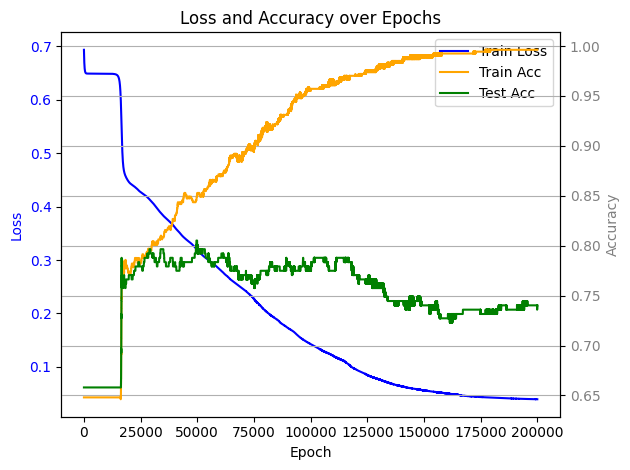


Minimum loss: 0.039579
Maximum train accuracy: 0.9963
Maximum test accuracy: 0.8052

=== Training Model 6/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 2, 'hidden2_size': 2, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648648 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.646351 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.462231 | Train Acc = 0.7765 | Test Acc = 0.7662
Epoch 90000: Loss = 0.462224 | Train Acc = 0.7765 | Test Acc = 0.7662
Epoch 100000: Loss = 0.462221 | Train Acc =

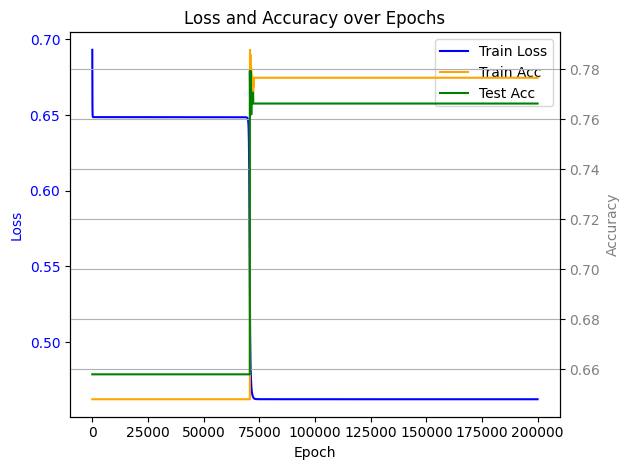


Minimum loss: 0.462209
Maximum train accuracy: 0.7877
Maximum test accuracy: 0.7792

=== Training Model 7/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.695127 | Train Acc = 0.3520 | Test Acc = 0.3420
Epoch 10000: Loss = 0.648641 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648630 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648602 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648536 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648343 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.647503 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.637873 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.495925 | Train Acc = 0.7821 | Test Acc = 0.7662
Epoch 90000: Loss = 0.468353 | Train Acc = 0.7728 | Test Acc = 0.7706
Epoch 100000: Loss = 0.466832 | Train Ac

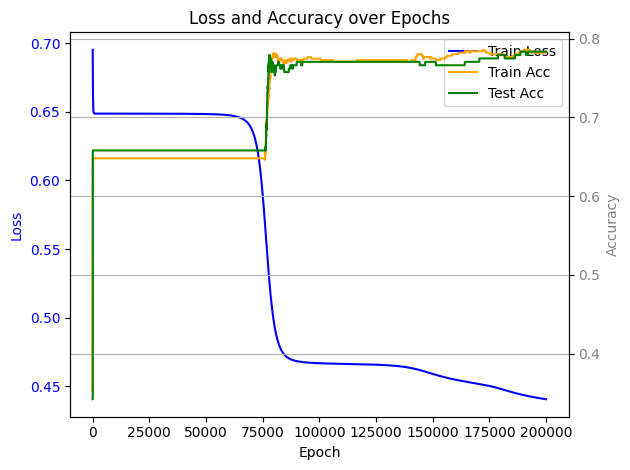


Minimum loss: 0.440602
Maximum train accuracy: 0.7858
Maximum test accuracy: 0.7835

=== Training Model 8/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648645 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648622 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.524217 | Train Acc = 0.7784 | Test Acc = 0.7576
Epoch 40000: Loss = 0.434201 | Train Acc = 0.7858 | Test Acc = 0.7706
Epoch 50000: Loss = 0.419733 | Train Acc = 0.7933 | Test Acc = 0.8009
Epoch 60000: Loss = 0.394669 | Train Acc = 0.8194 | Test Acc = 0.7749
Epoch 70000: Loss = 0.374497 | Train Acc = 0.8380 | Test Acc = 0.7749
Epoch 80000: Loss = 0.371011 | Train Acc = 0.8361 | Test Acc = 0.7706
Epoch 90000: Loss = 0.366058 | Train Acc = 0.8343 | Test Acc = 0.7879
Epoch 100000: Loss = 0.364763 | Train Acc =

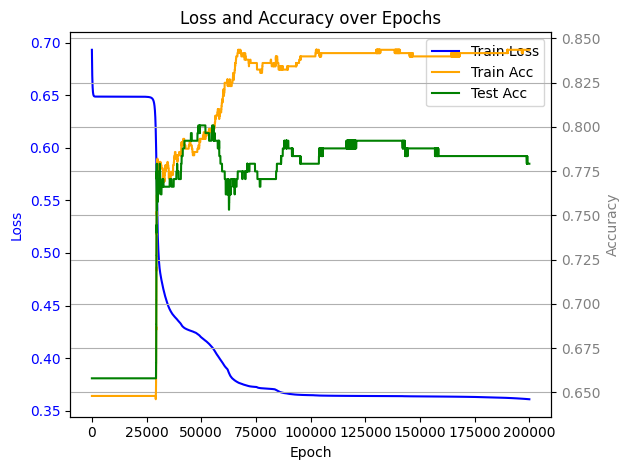


Minimum loss: 0.360884
Maximum train accuracy: 0.8436
Maximum test accuracy: 0.8009

=== Training Model 9/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693150 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648627 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.467636 | Train Acc = 0.7728 | Test Acc = 0.7662
Epoch 30000: Loss = 0.459353 | Train Acc = 0.7765 | Test Acc = 0.7662
Epoch 40000: Loss = 0.433456 | Train Acc = 0.7803 | Test Acc = 0.8009
Epoch 50000: Loss = 0.403674 | Train Acc = 0.8026 | Test Acc = 0.7749
Epoch 60000: Loss = 0.376389 | Train Acc = 0.8324 | Test Acc = 0.7576
Epoch 70000: Loss = 0.350461 | Train Acc = 0.8361 | Test Acc = 0.7619
Epoch 80000: Loss = 0.331024 | Train Acc = 0.8473 | Test Acc = 0.7835
Epoch 90000: Loss = 0.319661 | Train Acc = 0.8473 | Test Acc = 0.7879
Epoch 100000: Loss = 0.313038 | Train Acc =

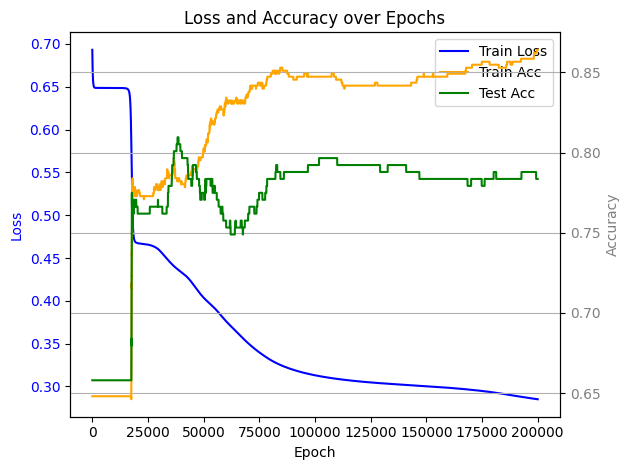


Minimum loss: 0.285062
Maximum train accuracy: 0.8641
Maximum test accuracy: 0.8095

=== Training Model 10/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693148 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648643 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648580 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.473421 | Train Acc = 0.7784 | Test Acc = 0.7662
Epoch 40000: Loss = 0.435880 | Train Acc = 0.7840 | Test Acc = 0.7879
Epoch 50000: Loss = 0.421843 | Train Acc = 0.7952 | Test Acc = 0.7706
Epoch 60000: Loss = 0.411007 | Train Acc = 0.7989 | Test Acc = 0.7749
Epoch 70000: Loss = 0.384374 | Train Acc = 0.8212 | Test Acc = 0.7489
Epoch 80000: Loss = 0.375742 | Train Acc = 0.8231 | Test Acc = 0.7446
Epoch 90000: Loss = 0.369102 | Train Acc = 0.8231 | Test Acc = 0.7489
Epoch 100000: Loss = 0.363305 | Train Acc 

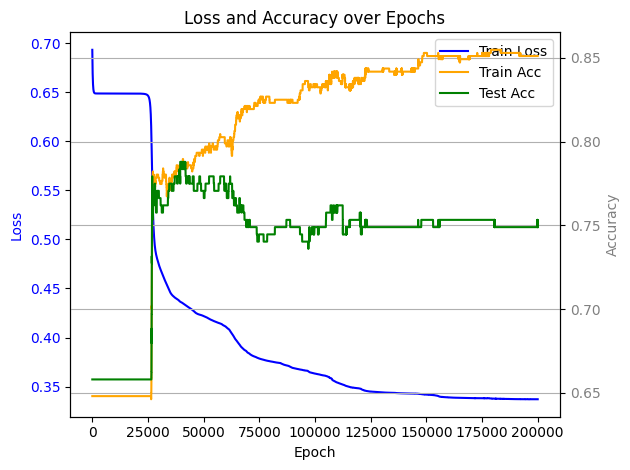


Minimum loss: 0.337170
Maximum train accuracy: 0.8547
Maximum test accuracy: 0.7879

=== Training Model 11/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.2, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.375391 | Train Acc = 0.8250 | Test Acc = 0.7576
Epoch 20000: Loss = 0.375098 | Train Acc = 0.8250 | Test Acc = 0.7576
Epoch 30000: Loss = 0.367041 | Train Acc = 0.8343 | Test Acc = 0.7749
Epoch 40000: Loss = 0.358342 | Train Acc = 0.8380 | Test Acc = 0.7576
Epoch 50000: Loss = 0.356073 | Train Acc = 0.8492 | Test Acc = 0.7532
Epoch 60000: Loss = 0.357275 | Train Acc = 0.8454 | Test Acc = 0.7706
Epoch 70000: Loss = 0.358032 | Train Acc = 0.8454 | Test Acc = 0.7706
Epoch 80000: Loss = 0.355948 | Train Acc = 0.8436 | Test Acc = 0.7662
Epoch 90000: Loss = 0.357776 | Train Acc = 0.8436 | Test Acc = 0.7576
Epoch 100000: Loss = 0.355532 | Train Acc =

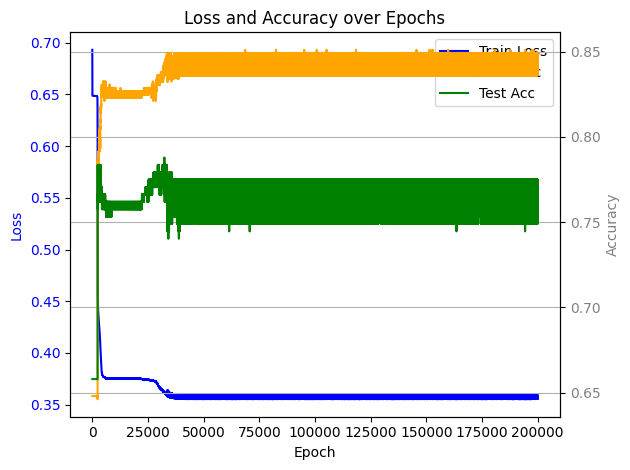


Minimum loss: 0.355225
Maximum train accuracy: 0.8510
Maximum test accuracy: 0.7879

=== Training Model 12/12 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.649038 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648651 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.648646 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.648646 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 90000: Loss = 0.648646 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 100000: Loss = 0.648645 | Train Acc

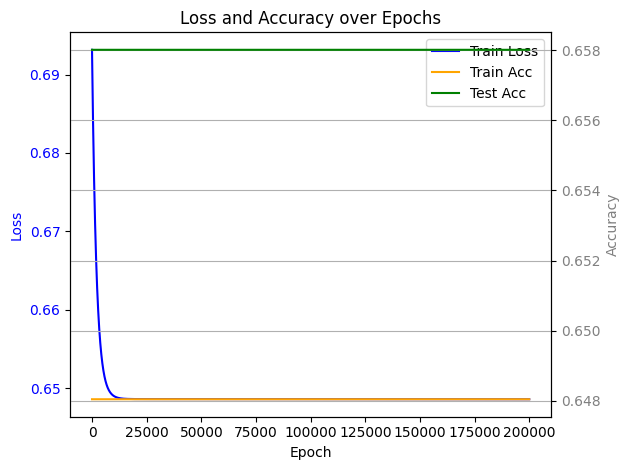


Minimum loss: 0.648626
Maximum train accuracy: 0.6480
Maximum test accuracy: 0.6580


In [4]:
# Neues training 



from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    train_accuracies = []   # neu
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Train-Accuracy berechnen
        y_pred_train = model.predict(X_train)
        y_pred_train_bin = (y_pred_train > 0.5).astype(int)
        acc_train = accuracy_score(y_train, y_pred_train_bin)
        train_accuracies.append(acc_train)

        # Test-Accuracy (falls verfügbar)
        if X_test is not None and y_test is not None:
            y_pred_test = model.predict(X_test)
            y_pred_test_bin = (y_pred_test > 0.5).astype(int)
            acc_test = accuracy_score(y_test, y_pred_test_bin)
            test_accuracies.append(acc_test)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}", end='')
            if X_test is not None:
                print(f" | Test Acc = {acc_test:.4f}")
            else:
                print()

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Accuracies
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc", color='orange')
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Acc", color='green')
    ax2.set_ylabel("Accuracy", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Legende zusammenführen
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")
    
    return losses, train_accuracies, test_accuracies




# Diabetes Dataset:
parameter_grid = [
    # Regularization
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.01},
    
    
    # Neurons 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.001}, # rule of thumb  
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.001}, # overfitting example  
    {'input_size': 8, 'hidden1_size': 2, 'hidden2_size': 2,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'relu','l2_lambda': 0.001}, # underfitting example

    # activation functions
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'tanh', 'l2_lambda': 0.001},  

    # Learning rates
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.2,  'activation_hidden': 'relu', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 1, 'lr': 0.001,  'activation_hidden': 'relu', 'l2_lambda': 0.001} 
    
]

results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, train_accuracies, test_accuracies = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=200000,
        patience=200000,
        print_every=10000
)
    
    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })




## Visualization of the network 

Epoch 10000:
  Model1 (ReLU):  Loss = 0.6486
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.6486
Epoch 20000:
  Model1 (ReLU):  Loss = 0.6486
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.4666
Epoch 30000:
  Model1 (ReLU):  Loss = 0.4786
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.4519
Epoch 40000:
  Model1 (ReLU):  Loss = 0.4286
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.4274
Epoch 50000:
  Model1 (ReLU):  Loss = 0.4166
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.3986
Epoch 60000:
  Model1 (ReLU):  Loss = 0.4062
  Model2 (ReLU):  Loss = 0.6486
  Model3 (Tanh):  Loss = 0.3733
Epoch 70000:
  Model1 (ReLU):  Loss = 0.3927
  Model2 (ReLU):  Loss = 0.6484
  Model3 (Tanh):  Loss = 0.3487
Epoch 80000:
  Model1 (ReLU):  Loss = 0.3841
  Model2 (ReLU):  Loss = 0.6479
  Model3 (Tanh):  Loss = 0.3363
Epoch 90000:
  Model1 (ReLU):  Loss = 0.3777
  Model2 (ReLU):  Loss = 0.6443
  Model3 (Tanh):  Loss = 0.3292
Epoch 100000:
  Mod

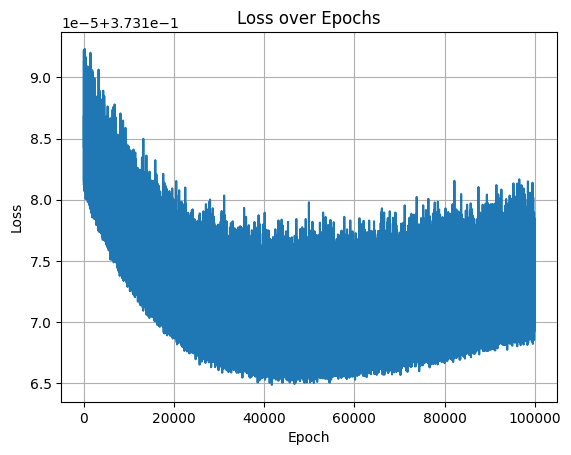

In [ ]:
# define NN with:     #{'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.01,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
# Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}

# === Training Model 1/12 ===
#Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}


model = NeuralNetwork(
    input_size=8, 
    hidden1_size=6, 
    hidden2_size=4,  
    output_size=1, 
    lr=0.01,  
    activation_hidden='relu', 
    l2_lambda=0.001
)

model2 = NeuralNetwork(
    input_size=8, 
    hidden1_size=6, 
    hidden2_size=4,  
    output_size=1, 
    lr=0.01,  
    activation_hidden='sigmoid', 
    l2_lambda=0.001
) 

model3 = NeuralNetwork(
    input_size=8, 
    hidden1_size=6, 
    hidden2_size=4,  
    output_size=1, 
    lr=0.01,  
    activation_hidden='tanh', 
    l2_lambda=0.001
)


# train the models
epochs = 200000
losses_model1 = []
losses_model2 = []
losses_model3 = []

for epoch in range(epochs):
    loss1 = model.train(X_train, y_train)
    loss2 = model2.train(X_train, y_train)
    loss3 = model3.train(X_train, y_train)

    losses_model1.append(loss1)
    losses_model2.append(loss2)
    losses_model3.append(loss3)

    if (epoch + 1) % 10000 == 0:
        print(f"Epoch {epoch+1}:")
        print(f"  Model1 (ReLU):  Loss = {loss1:.4f}")
        print(f"  Model2 (ReLU):  Loss = {loss2:.4f}")
        print(f"  Model3 (Tanh):  Loss = {loss3:.4f}")




# Train the model
losses = []
for epoch in range(100000):
    loss = model.train(X_train, y_train)
    losses.append(loss)
    
    #if epoch % 1000 == 0:
        #print(f"Epoch {epoch}: Loss = {loss:.6f}")

# Plot the loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.show()




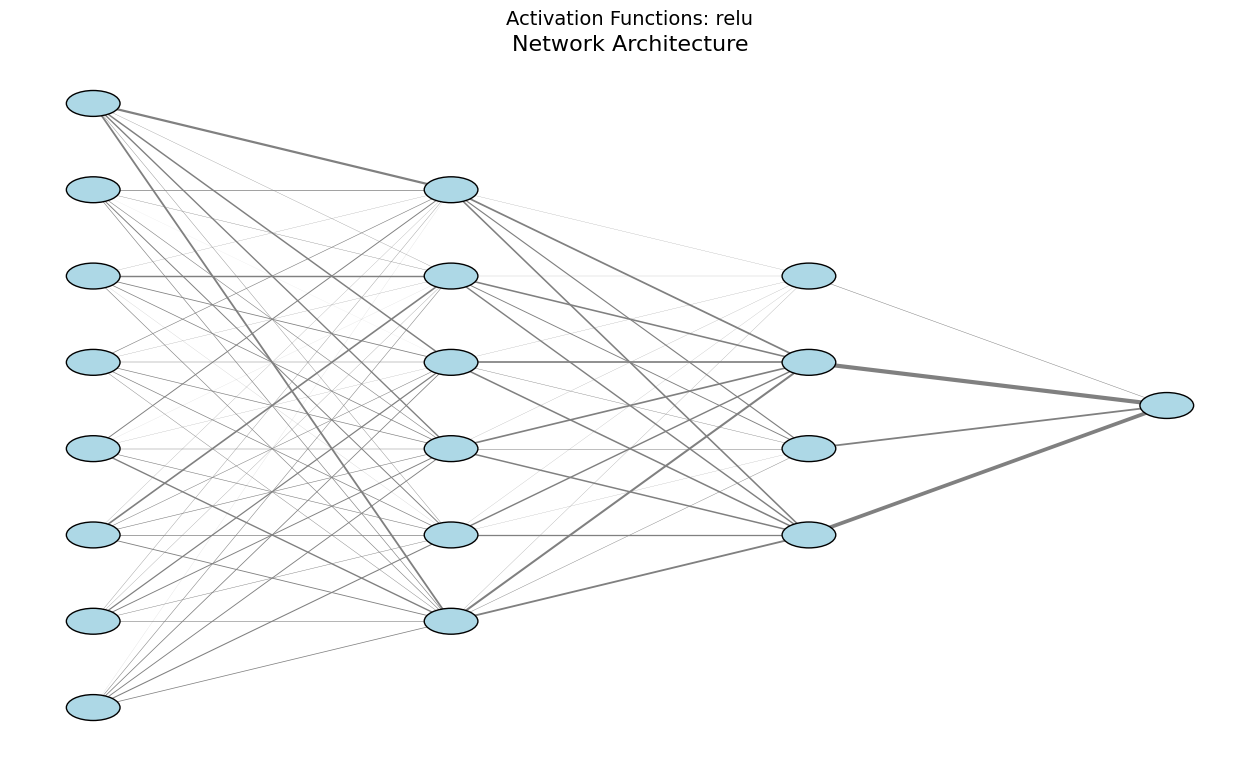

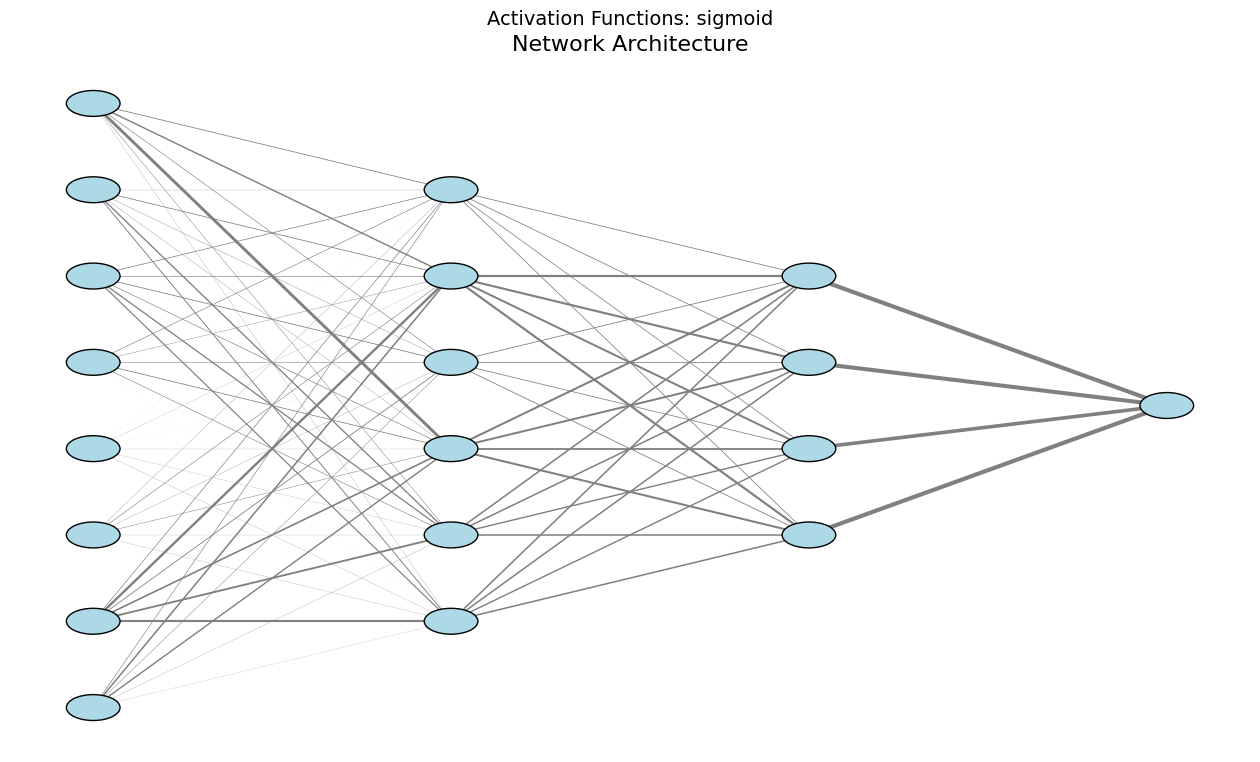

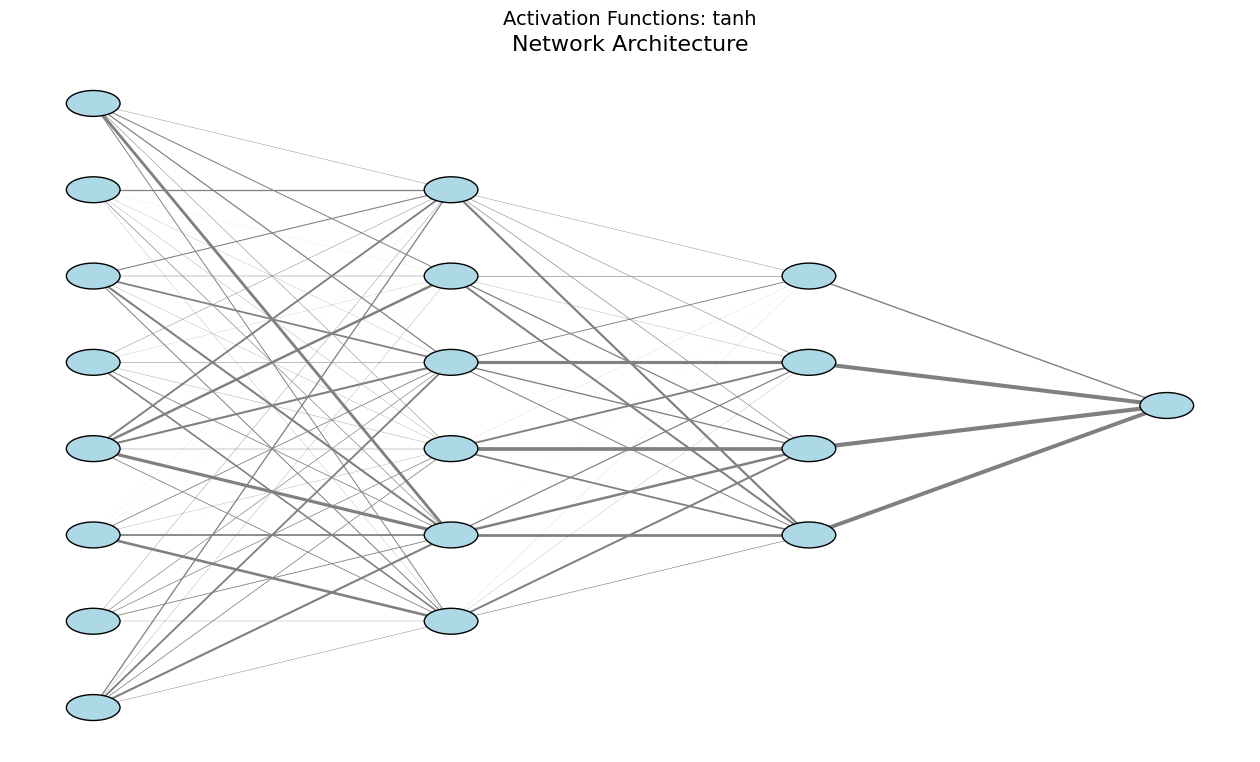

In [28]:
# LLM generated code to visualize the network architecture
import matplotlib.pyplot as plt
import numpy as np

def plot_network(model):
    # Layer-Größen auslesen
    sizes = [
        model.w0.shape[1],  # Input
        model.w0.shape[0],  # Hidden1
        model.w1.shape[0],  # Hidden2
        model.w2.shape[0]   # Output
    ]
    
    v_spacing, h_spacing = 1.0, 2.0
    positions = {}
    # Knoten-Positionen
    for layer_idx, n in enumerate(sizes):
        y_coords = np.linspace(- (n-1)*v_spacing/2, (n-1)*v_spacing/2, n)
        for neuron_idx, y in enumerate(y_coords):
            positions[(layer_idx, neuron_idx)] = (layer_idx*h_spacing, y)
    
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # Knoten zeichnen
    for (l, n), (x, y) in positions.items():
        circ = plt.Circle((x, y), 0.15, color='lightblue', ec='black', zorder=3)
        ax.add_patch(circ)
    
    # Kanten (Gewichte) zeichnen
    weights = [model.w0, model.w1, model.w2]
    max_w = max(np.abs(w).max() for w in weights)
    
    for layer_idx, W in enumerate(weights):
        for i_out in range(W.shape[0]):
            for i_in in range(W.shape[1]):
                x1, y1 = positions[(layer_idx,   i_in)]
                x2, y2 = positions[(layer_idx+1, i_out)]
                w = W[i_out, i_in]
                lw = (abs(w)/max_w) * 3  
                ax.plot([x1, x2], [y1, y2], linewidth=lw, color='gray', zorder=1)
    
    ax.set_title("Network Architecture", fontsize=16)
    # sub title with activation functions
    ax.text(0.5, 1.05, f"Activation Functions: {model.activation_hidden}", 
            horizontalalignment='center', fontsize=14, transform=ax.transAxes)
    
    ax.axis('off')
    plt.show()


#model = NeuralNetwork(input_size=8, hidden1_size=6, hidden2_size=4, output_size=1)
plot_network(model)
plot_network(model2)
plot_network(model3)

Accuracy: 0.6948


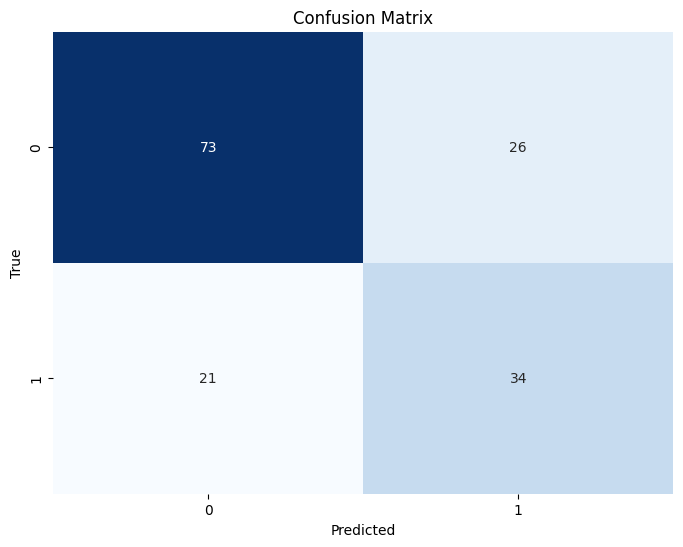

Confusion Matrix:
[[73 26]
 [21 34]]
Mean y_pred: 0.391073419345021


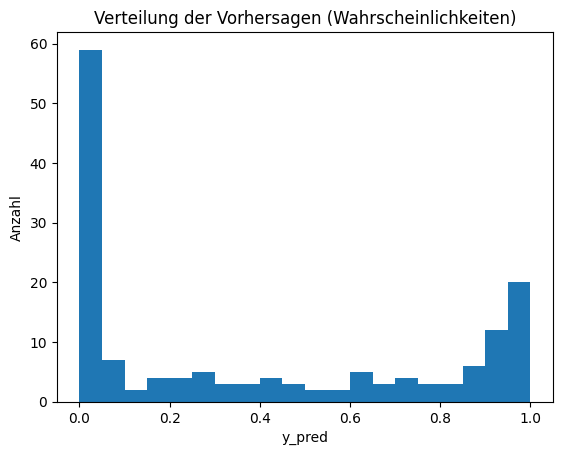

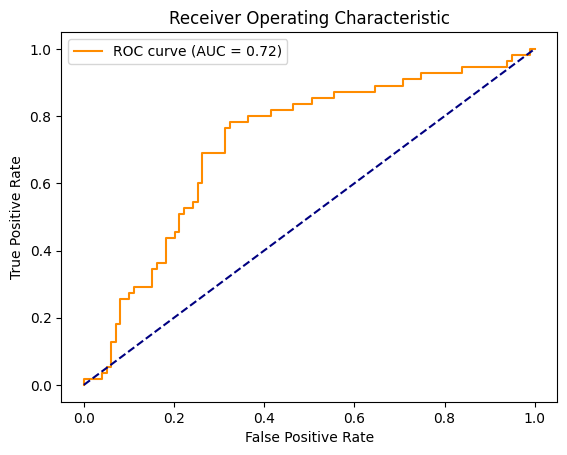

In [86]:
# Predict 
y_pred = model.predict(X_test)
# Convert predictions to binary with a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)
y_test_binary = y_test.astype(int)


# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test_binary)
print(f"Accuracy: {accuracy:.4f}")

# confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print confusion matrix
print("Confusion Matrix:")
print(cm)

print("Mean y_pred:", np.mean(y_pred))


import matplotlib.pyplot as plt
plt.hist(y_pred, bins=20)
plt.title("Verteilung der Vorhersagen (Wahrscheinlichkeiten)")
plt.xlabel("y_pred")
plt.ylabel("Anzahl")
plt.show()


from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


## Model stats 

In [6]:
from pympler import asizeof

def get_model_stats(model):
    import numpy as np

 
    arrays = [model.w0, model.b0, model.w1, model.b1, model.w2, model.b2]
    
    # number of paramters (all weights + biases)
    total_params = sum(arr.size for arr in arrays)

    # RAM
    size_bytes = asizeof.asizeof(model)
    # bytes into MB
    total_MB = size_bytes / (1024 ** 2)

    print(f"Total learnable parameters: {total_params:,}")
    print(f"Total size in RAM: {total_MB:.2f} MB")

    return total_params, total_MB


get_model_stats(model)

Total learnable parameters: 6,001
Total size in RAM: 0.24 MB


(6001, 0.24430084228515625)

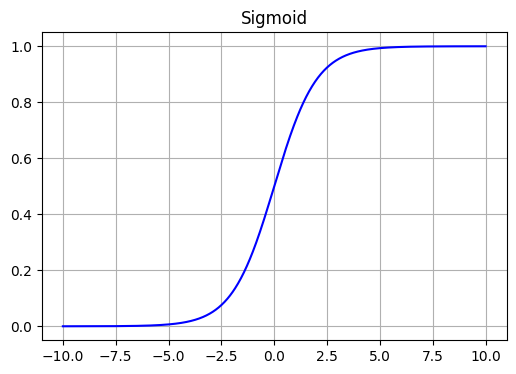

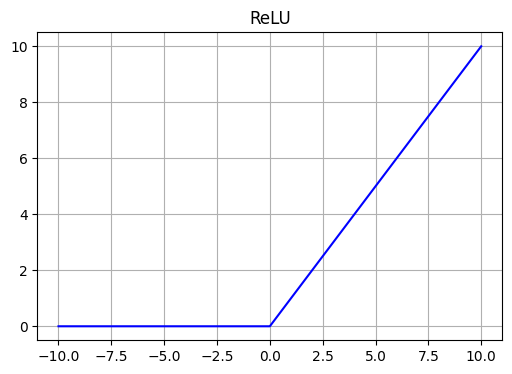

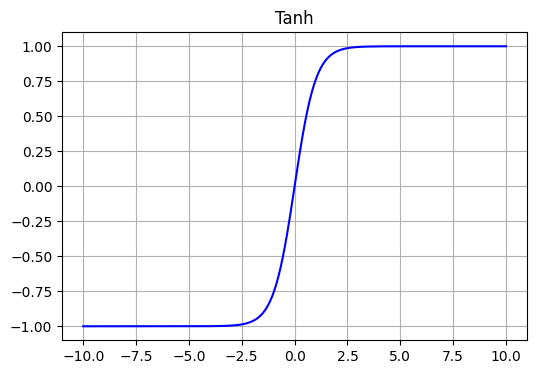

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# Wertebereich
x = np.linspace(-10, 10, 1000)

# Auswerten der Funktionen
sig = sigmoid(x)

r = relu(x)

t = tanh(x)


# Einzelne Plots generieren
def plot_function(x, y, title, color='blue'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, color=color)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotten
plot_function(x, sig, 'Sigmoid')

plot_function(x, r, 'ReLU')

plot_function(x, t, 'Tanh')


# 2. PyTorch 

**Sequential Model:**

https://medium.com/writeasilearn/using-sequential-module-to-build-a-neural-network-a34ca3f37203


In [8]:
# Data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch

# Features: float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

# Targets: float32 UND als Spaltenvektor (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

# binary cross-entropy loss
criterion = nn.BCELoss() 

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01)
lr = 0.1

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()

    # Forward-Pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Zero gradients because PyTorch accumulates gradients
    model.zero_grad()

    # Backward-Pass (clac gradients)
    loss.backward()

    # Update manuelly
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6855
Epoch 100, Loss: 0.4597
Epoch 200, Loss: 0.4314
Epoch 300, Loss: 0.4159
Epoch 400, Loss: 0.4031
Epoch 500, Loss: 0.3918
Epoch 600, Loss: 0.3814
Epoch 700, Loss: 0.3711
Epoch 800, Loss: 0.3601
Epoch 900, Loss: 0.3491


Test Accuracy: 0.7273


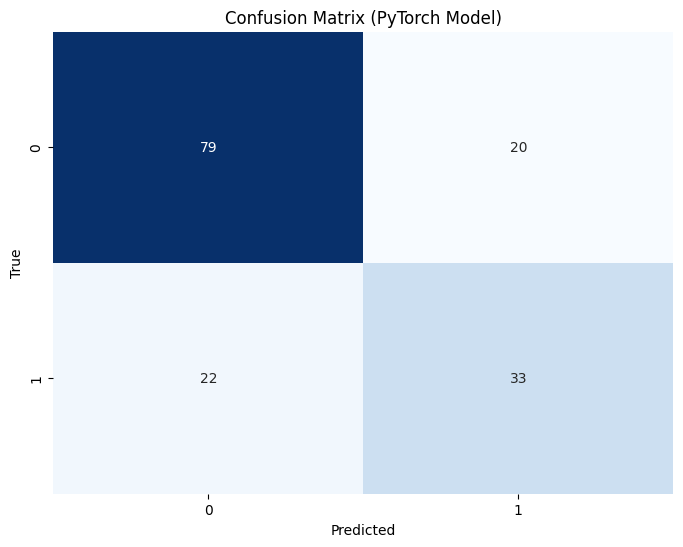

In [10]:
# Predict on test 
outputs_test = model(X_test_torch)
# Convert predictions to binary with a threshold of 0.5
y_pred_test = (outputs_test >= 0.5).float()
# Calculate accuracy
accuracy_test = (y_pred_test == y_test_torch).float().mean()
print(f"Test Accuracy: {accuracy_test:.4f}")
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test_torch.numpy(), y_pred_test.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PyTorch Model)')
plt.show()


# 3. LLM Implementation


Prompt: 
Implement a framework for neural networks (NN). Implement the entire network from scratch, including forward and backward propagation methods

In [83]:
import numpy as np

# Base class for layers
class Layer:
    def forward(self, input):
        raise NotImplementedError
        
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

# Dense (fully connected) layer
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.mean(output_gradient, axis=0, keepdims=True)
        return input_gradient

# Activation functions
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return self.activation_prime(self.input) * output_gradient

# Specific activation functions
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Loss function
class MeanSquaredError:
    def loss(self, predicted, actual):
        return np.mean(np.power(predicted - actual, 2))

    def gradient(self, predicted, actual):
        return 2 * (predicted - actual) / actual.size

# Neural network class
class NeuralNetwork2:
    def __init__(self):
        self.layers = []
        self.loss_fn = MeanSquaredError()

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.predict(x_train)
            loss = self.loss_fn.loss(output, y_train)
            grad = self.loss_fn.gradient(output, y_train)
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad, learning_rate)
            
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.2930
Epoch 100, Loss: 0.2377
Epoch 200, Loss: 0.2151
Epoch 300, Loss: 0.1953
Epoch 400, Loss: 0.1844
Epoch 500, Loss: 0.1796
Epoch 600, Loss: 0.1758
Epoch 700, Loss: 0.1720
Epoch 800, Loss: 0.1691
Epoch 900, Loss: 0.1671
Epoch 1000, Loss: 0.1654
Accuracy: 0.7150


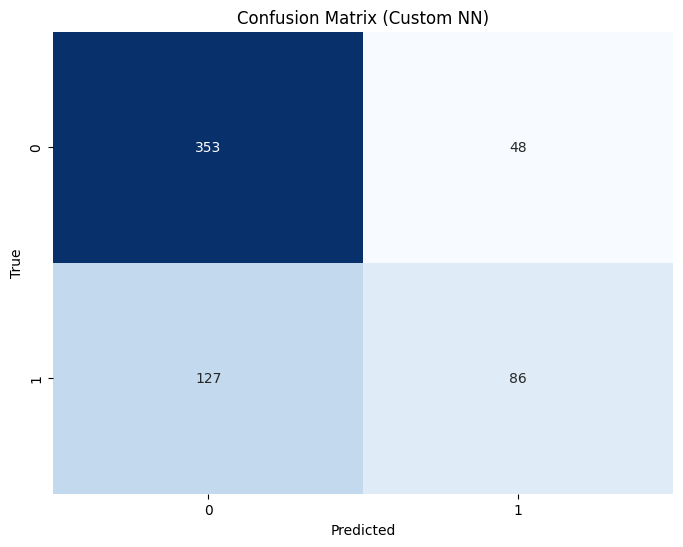

In [84]:
nn = NeuralNetwork2()
nn.add(Dense(8, 4))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(4, 1))
nn.add(Activation(sigmoid, sigmoid_prime))


nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Predictions
preds = nn.predict(X_train)
pred_classes = (preds >= 0.5).astype(int)

true_classes = y_train.reshape(-1, 1)

# Accuracy 
accuracy = np.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_nn = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Custom NN)')
plt.show()

